In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [21]:
path = untar_data(URLs.PETS)

In [22]:
path.ls()

[PosixPath('/home/subhaditya/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/subhaditya/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/subhaditya/.fastai/data/oxford-iiit-pet/small-256'),
 PosixPath('/home/subhaditya/.fastai/data/oxford-iiit-pet/small-96')]

In [25]:
path_hr = path / "small-256"
path_lr = path / "small-96"
il = ImageList.from_folder(path_hr)
il
bs, size = 32, 128
 

In [26]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct()
 

In [27]:
def get_data(bs, size):
    data = (
        src.label_from_func(lambda x: path_hr / x.name)
        .transform(get_transforms(max_zoom=2.0), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=True)
    )
 
    #     data.c = 3
    return data
 

In [28]:
data_gen = get_data(bs, size)

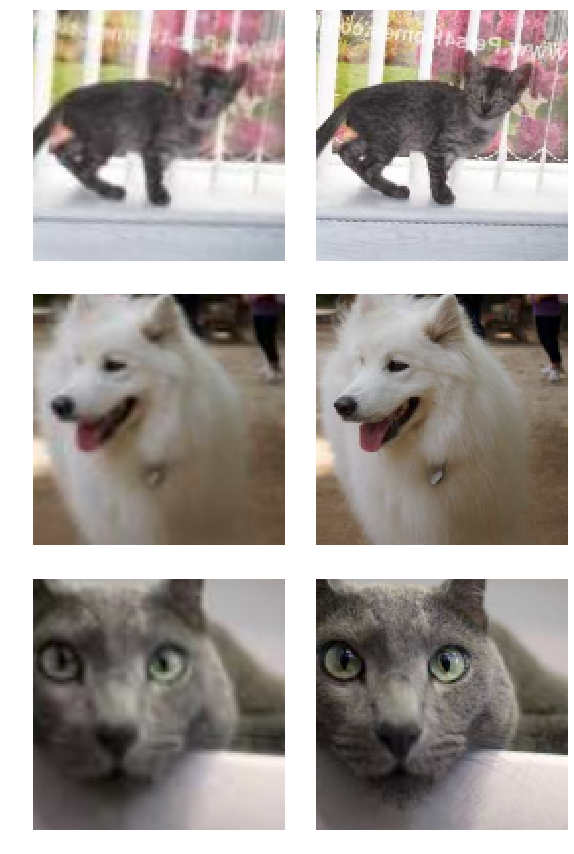

In [29]:
data_gen.show_batch(3)

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride) #, padding)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [8]:
class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample = nn.Upsample(scale_factor=upsample, mode='nearest')
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        out = self.relu(out)
        return out 



In [10]:
class ImageTransformNet(nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        
        # nonlineraity
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        # encoding layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1_e = nn.InstanceNorm2d(32, affine=True)

        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2_e = nn.InstanceNorm2d(64, affine=True)

        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3_e = nn.InstanceNorm2d(128, affine=True)

        # residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        # decoding layers
        self.deconv3 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2 )
        self.in3_d = nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2 )
        self.in2_d = nn.InstanceNorm2d(32, affine=True)

        self.deconv1 = UpsampleConvLayer(32, 3, kernel_size=9, stride=1)
        self.in1_d = nn.InstanceNorm2d(3, affine=True)

    def forward(self, x):
        # encode
        y = self.relu(self.in1_e(self.conv1(x)))
        y = self.relu(self.in2_e(self.conv2(y)))
        y = self.relu(self.in3_e(self.conv3(y)))

        # residual layers
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)

        # decode
        y = self.relu(self.in3_d(self.deconv3(y)))
        y = self.relu(self.in2_d(self.deconv2(y)))
        #y = self.tanh(self.in1_d(self.deconv1(y)))
        y = self.deconv1(y)

        return y

# Adam, MSELoss

In [31]:
model = ImageTransformNet()

In [32]:
learn = None
gc.collect()

412

In [33]:
learn = Learner(
    data_gen,
    model,
    callback_fns=ShowGraph,
    loss_func=MSELossFlat()
)

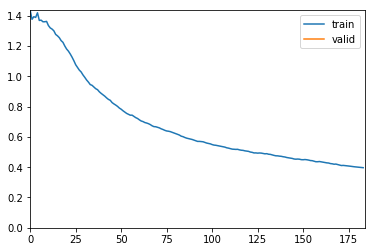

In [34]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-4, wd=10e-4)

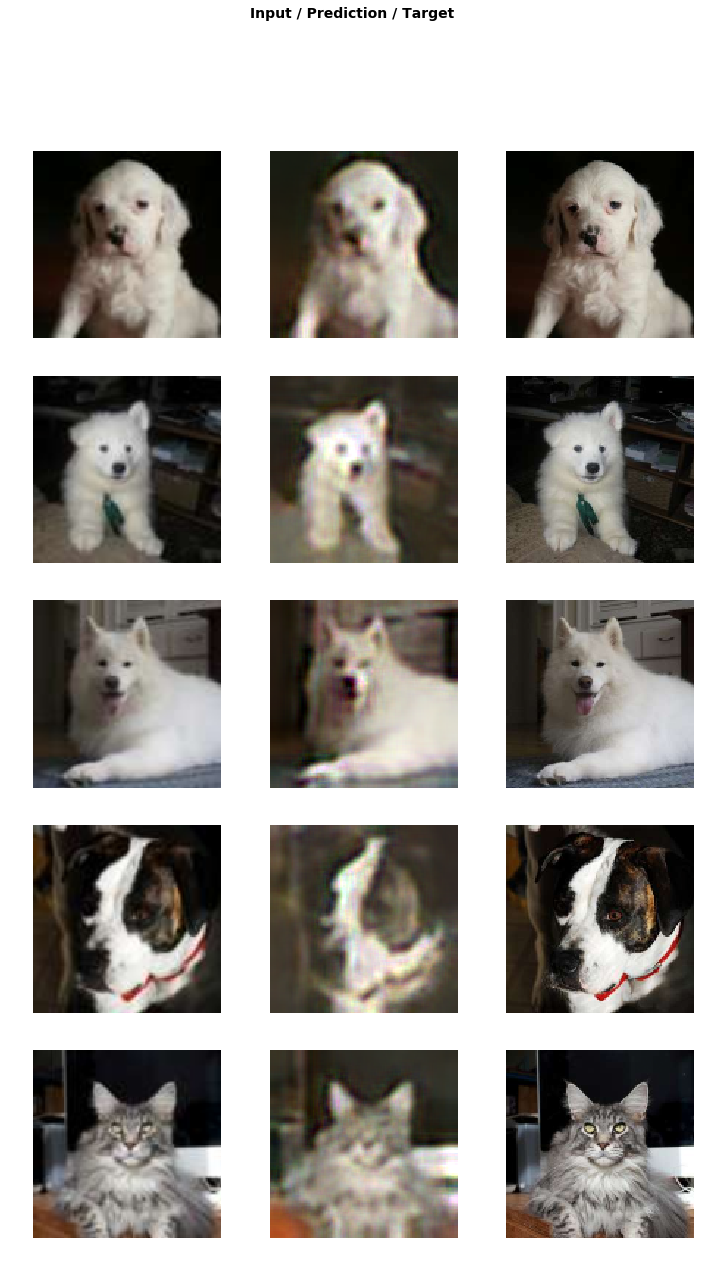

In [36]:
learn.show_results()

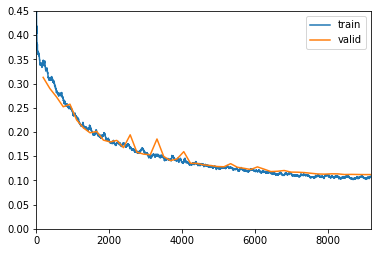

In [37]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-4, wd=10e-4)

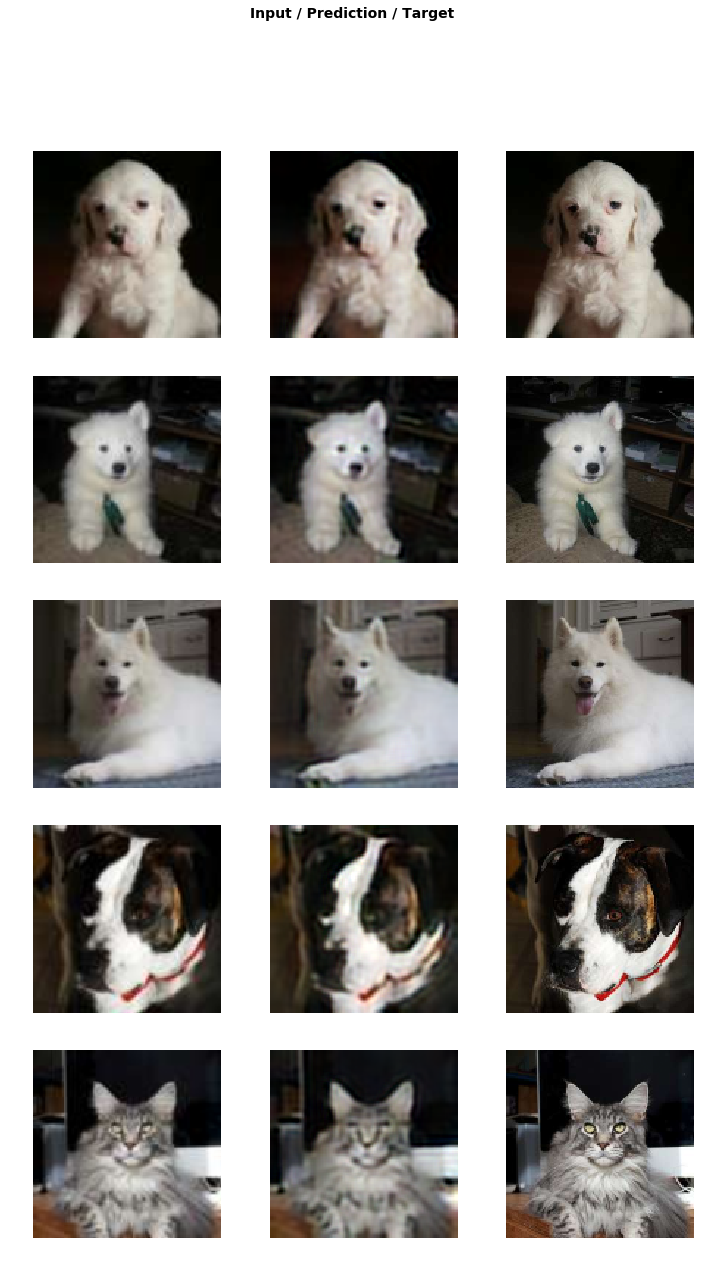

In [38]:
learn.show_results()

In [35]:
learn.save('stage-1')

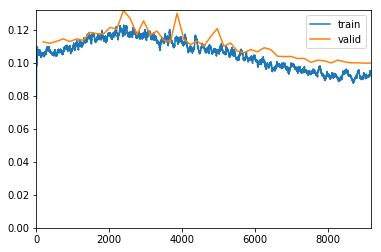

In [39]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-4, wd=10e-4)

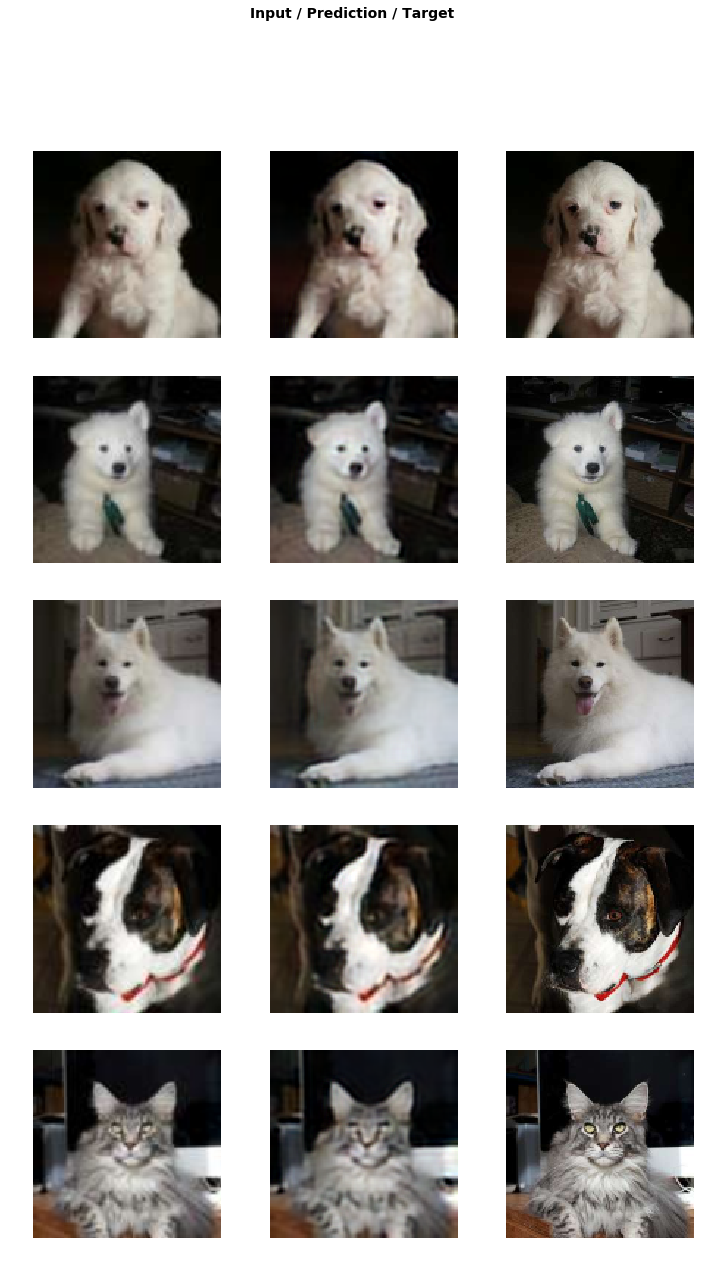

In [40]:
learn.show_results()

In [41]:
learn.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


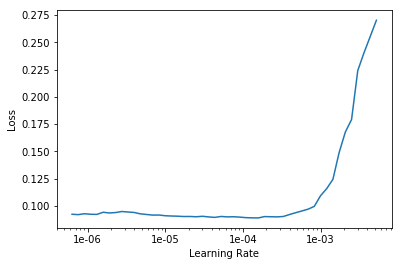

In [42]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

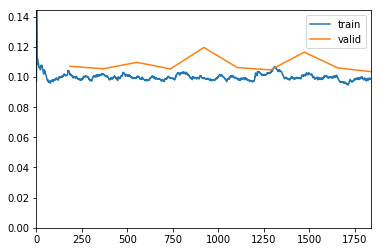

In [43]:
learn.unfreeze()
learn.fit(10, 6e-5, wd=10e-5)

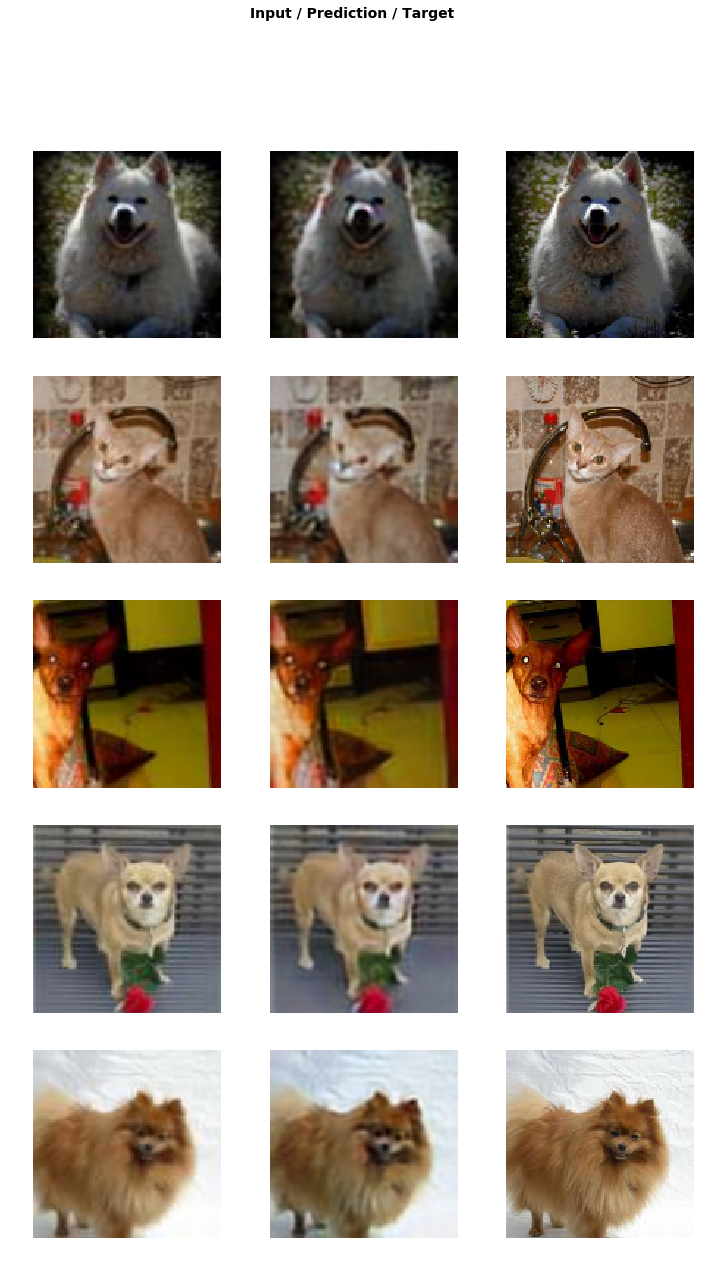

In [45]:
learn.show_results(20)

# RMS, MSELoss

In [48]:
from torch.optim import *

In [46]:
model = ImageTransformNet()

In [47]:
learn = None
gc.collect()

71501

In [50]:
learn = Learner(
    data_gen,
    model,
    callback_fns=ShowGraph,
    loss_func=MSELossFlat(),
    opt_func= RMSprop
)

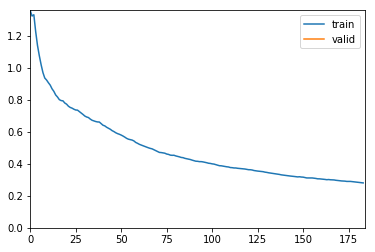

In [51]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-4, wd=10e-4)

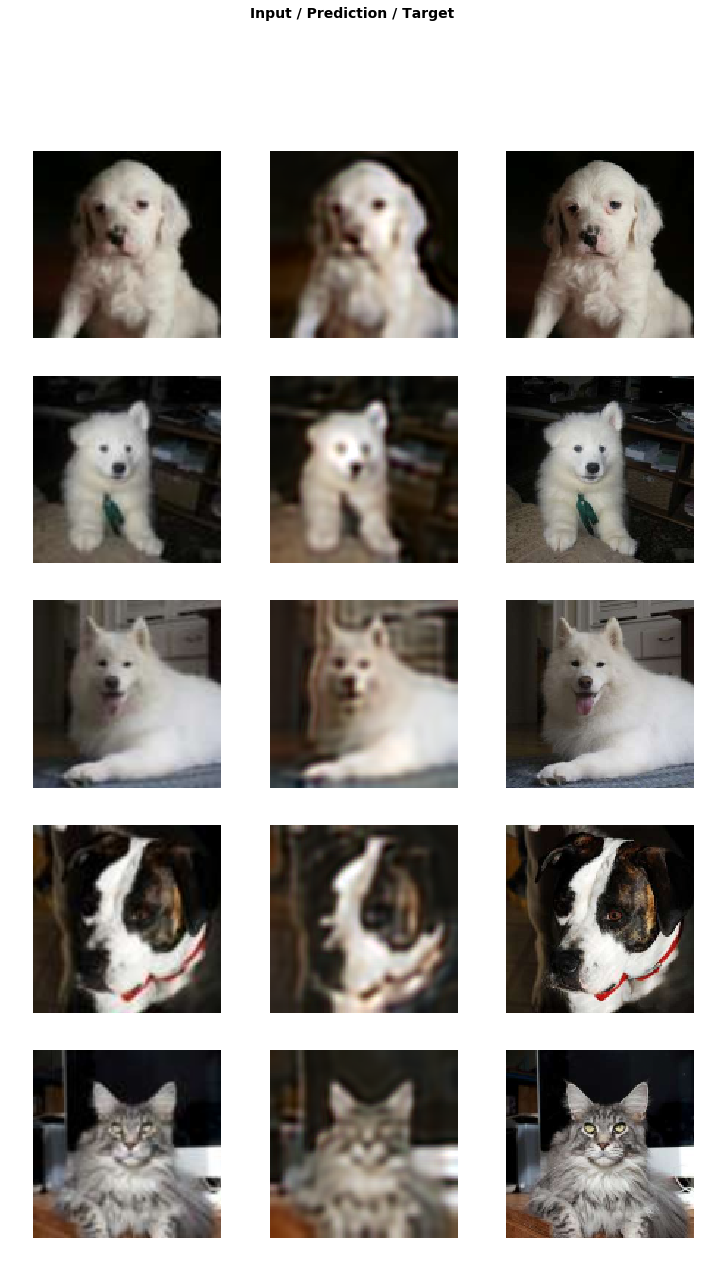

In [52]:
learn.show_results()

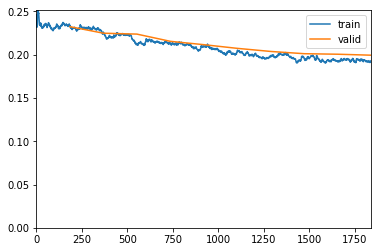

In [54]:
learn.unfreeze()
learn.fit_one_cycle(10, 3e-6, wd=10e-4)

In [55]:
learn.save('rms-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


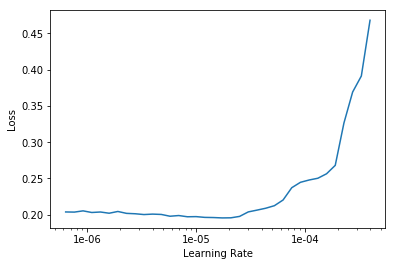

In [56]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

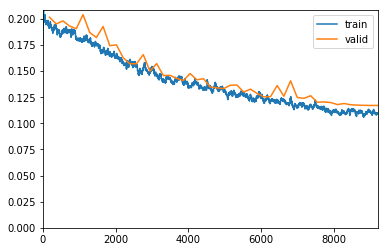

In [57]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-5, wd=10e-3)

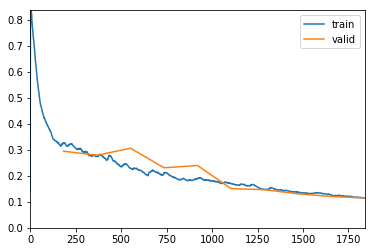

In [58]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, wd=10e-2)

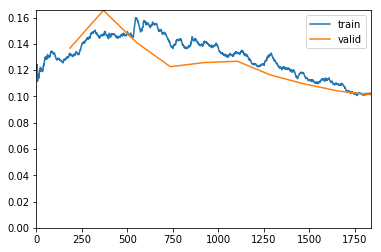

In [59]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, wd=10e-2)

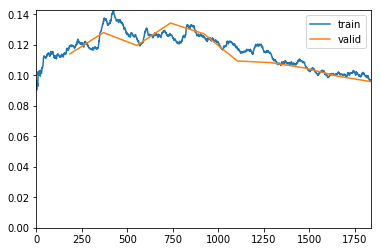

In [61]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, wd=10e-2)

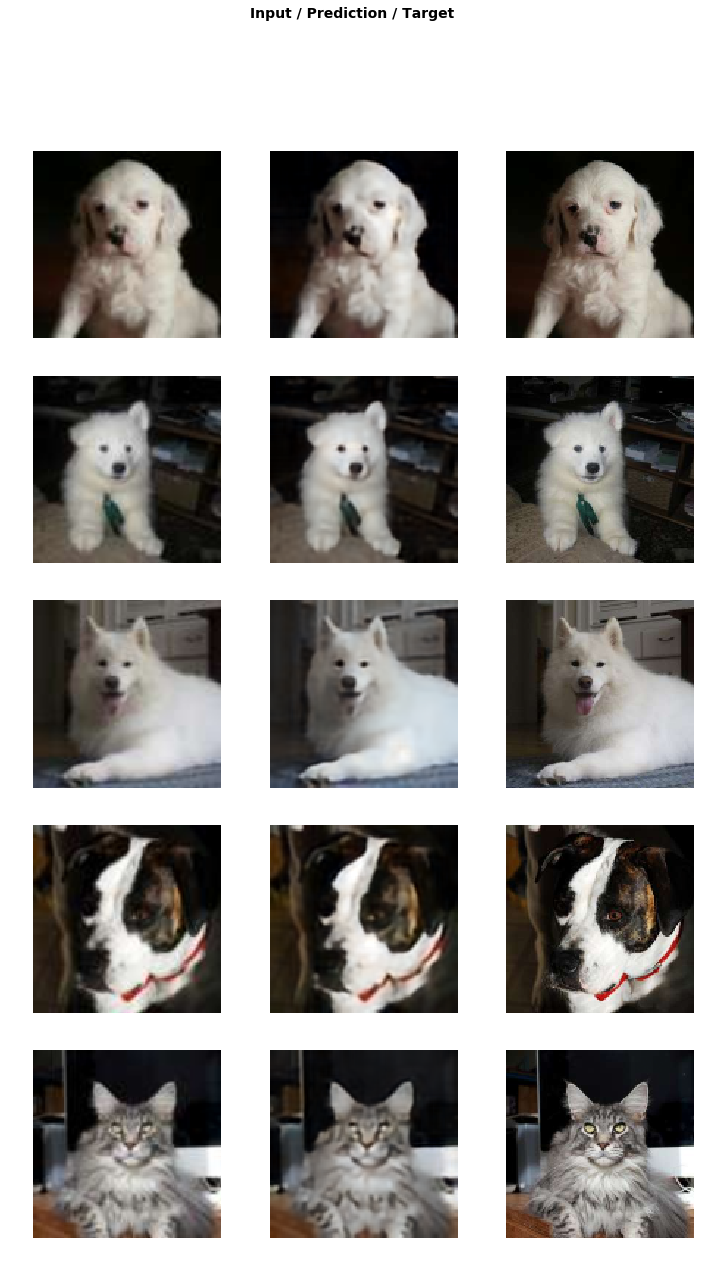

In [62]:
learn.show_results()

# AdamW

In [63]:
model = ImageTransformNet()

In [64]:
learn = None
gc.collect()

118035

In [65]:
learn = Learner(
    data_gen,
    model,
    callback_fns=ShowGraph,
    loss_func=MSELossFlat(),
    opt_func= AdamW
)

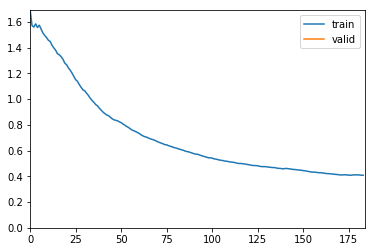

In [66]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-4, wd=10e-4)

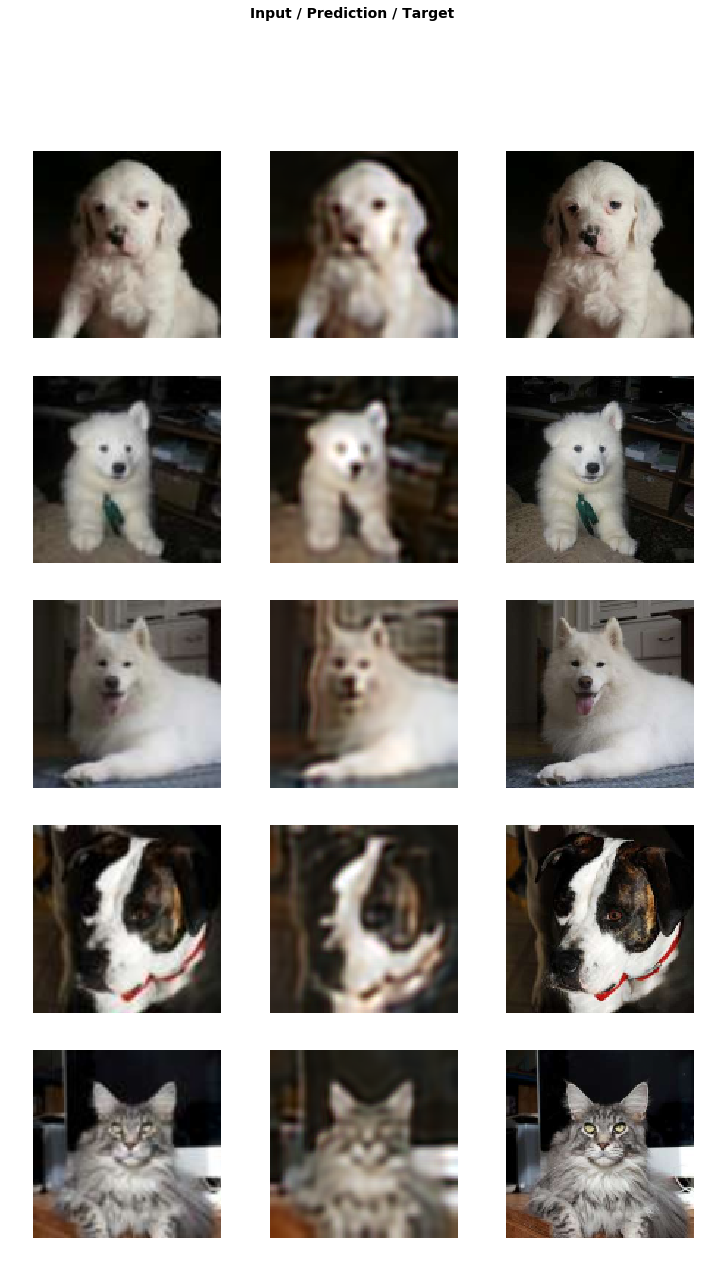

In [52]:
learn.show_results()

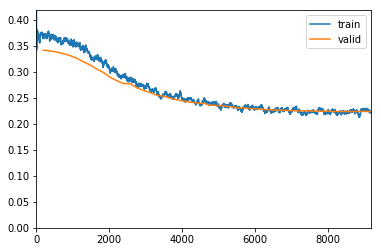

In [67]:
learn.unfreeze()
learn.fit_one_cycle(50, 3e-6, wd=10e-4)

In [68]:
learn.save('adamw-1')

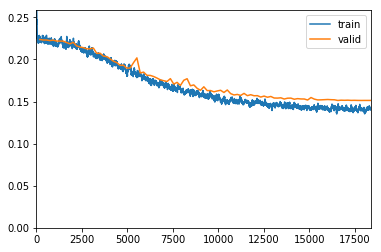

In [69]:
learn.unfreeze()
learn.fit_one_cycle(100, 1e-5, wd=10e-3)

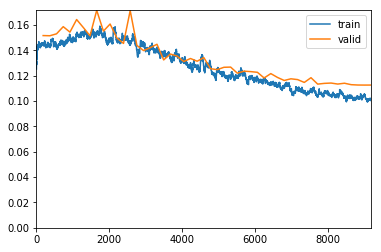

In [71]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-4, wd=10e-2)

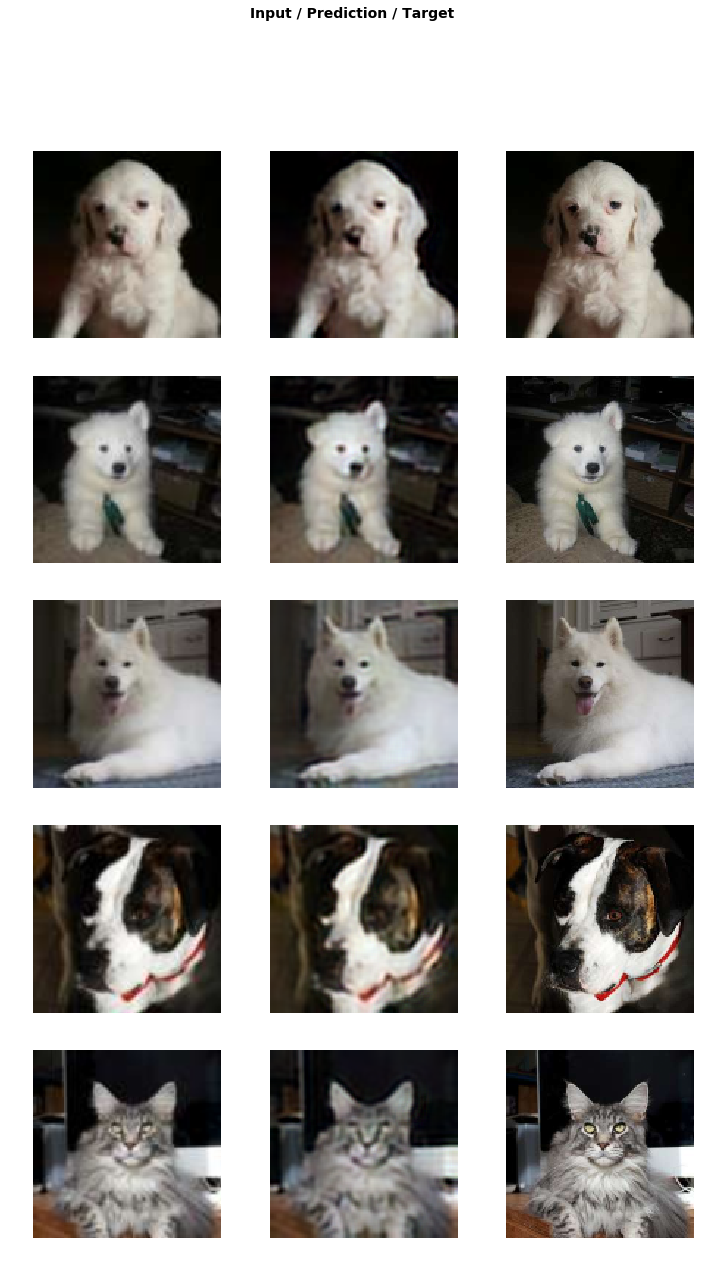

In [72]:
learn.show_results()

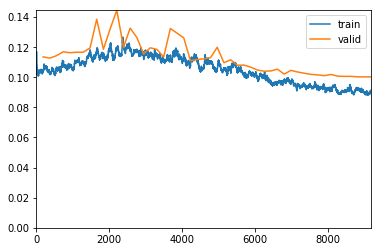

In [73]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-4, wd=10e-2)

In [74]:
learn.save('adamw-2')

In [77]:
learn.load('adamw-2')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/subhaditya/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (1478 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/subhaditya/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=ImageTransformNet(
  (relu): ReLU()
  (tanh): Tanh()
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1_e): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): Conv

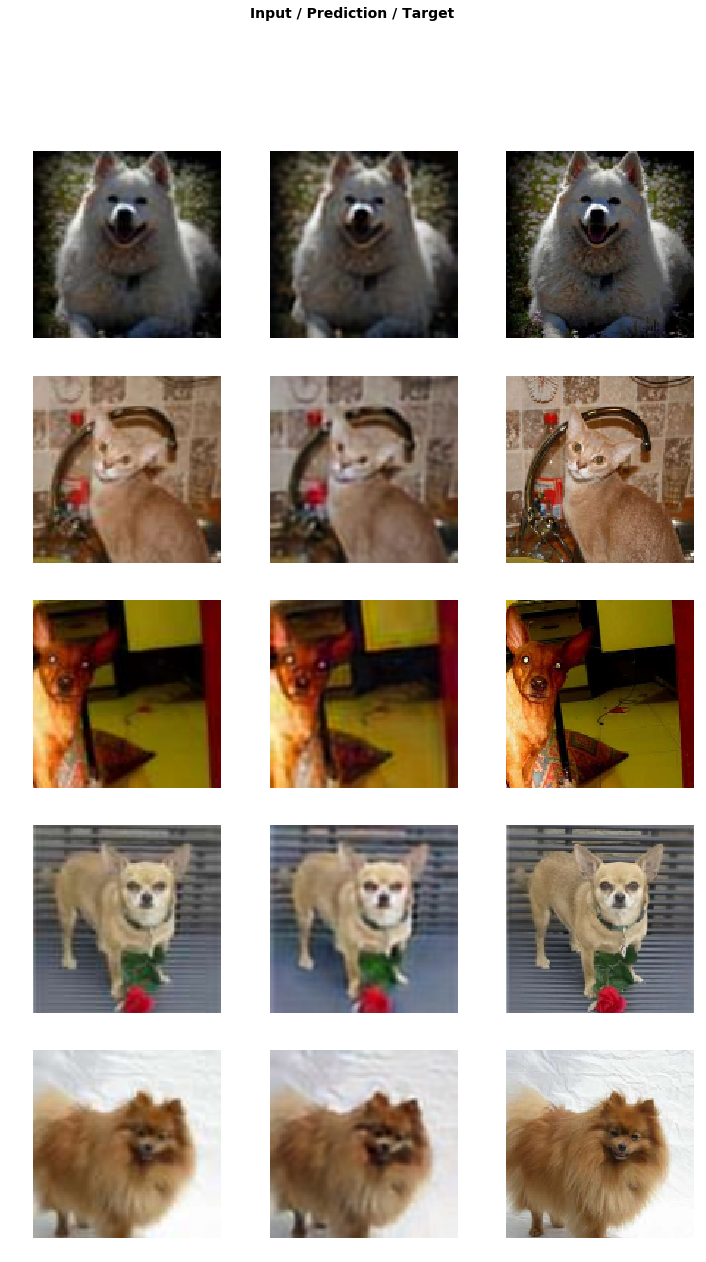

In [79]:
learn.show_results(30)